# ARC Fuel Cycle - Replication of Meschini Residence Time Model using PathView

This notebook loads the `arc_same_as_meschini.pvm` PathView model from the `/pathview_graphs/` directory, runs the simulation, and saves the results to the `/results/` directory. It then plots the scope outputs and saves these to the `/plots/` directory.

In [ ]:
# Load the model and create pathsim simulations

# Run the simulation

# Save the results as npz files

# Plot the results
    # - Inventory evolution & comparison with Meschini data
    # - Temporal evolution of storage & blanket inventories vs fusion rate

# Save the plots

In [1]:
import pathview
import json
from pathsim.blocks import Scope
import matplotlib.pyplot as plt
import pandas as pd

# read graph data from a JSON file
with open("arc_same_as_meschini.json", "r") as f:
    graph_data = json.load(f)

model, duration = pathview.make_pathsim_model(graph_data)

model.run(300 * 24 * 3600)


KeyError: 'sampling_period'

In [ ]:
# read data from a url
url = "https://raw.githubusercontent.com/SamueleMeschini/fuel-cycle/refs/heads/main/postprocessing/data/inventory_evolution_tbz1h.csv"
data_meschini = pd.read_csv(url)
data_meschini

,time [s],blanket inventory [kg],TES inventory [kg],ISS inventory [kg],storage inventory [kg],Unnamed: 5,Unnamed: 6,Unnamed: 7
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.140000,NaN,NaN,NaN
1,1.000000e-04,9.590000e-11,1.070000e-18,2.380000e-24,1.140000,NaN,NaN,NaN
2,6.000000e-04,5.760000e-10,3.840000e-17,5.140000e-22,1.140000,NaN,NaN,NaN
3,3.100000e-03,2.970000e-09,1.020000e-15,7.090000e-20,1.140000,NaN,NaN,NaN
4,1.560000e-02,1.500000e-08,2.590000e-14,9.030000e-18,1.139999,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
577783,9.460761e+07,3.282300e-03,6.162572e-02,2.588897e-01,3.509977,NaN,NaN,NaN
577784,9.460761e+07,3.281900e-03,6.162573e-02,2.588901e-01,3.509996,NaN,NaN,NaN
577785,9.460776e+07,3.181202e-03,6.162642e-02,2.589760e-01,3.514562,NaN,NaN,NaN
577786,9.460782e+07,3.141250e-03,6.162576e-02,2.590037e-01,3.516333,NaN,NaN,NaN


In [ ]:
import morethemes as mt
mt.set_theme("lighter")

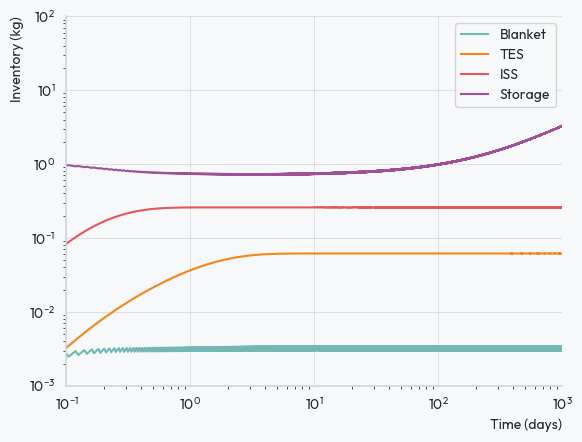

In [ ]:
time_days = data_meschini["time [s]"] / 3600 / 24
plt.plot(time_days, data_meschini["blanket inventory [kg]"], label="Blanket")
plt.plot(time_days, data_meschini["TES inventory [kg]"], label="TES")
plt.plot(time_days, data_meschini["ISS inventory [kg]"], label="ISS")
plt.plot(time_days, data_meschini["storage inventory [kg]"], label="Storage")

plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-3, 1e2)
plt.xlim(1e-1, 1e3)
plt.xlabel("Time (days)")
plt.ylabel("Inventory (kg)")
plt.legend()

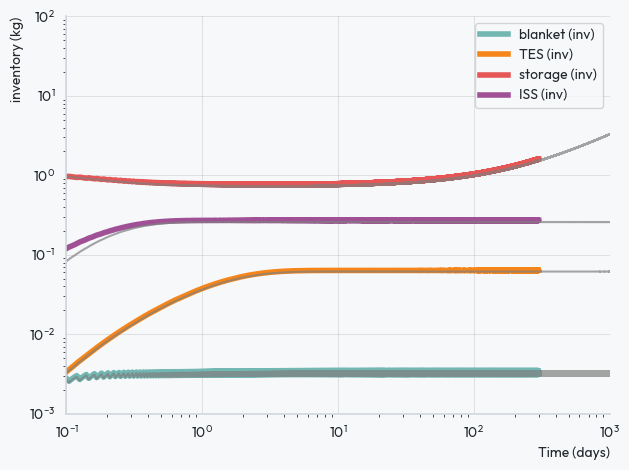

In [ ]:
scopes = [block for block in model.blocks if isinstance(block, Scope)]

ifc_scope = scopes[0]
ofc_scope = scopes[2]
fusion_rate_scope = scopes[1]

for scope in [ofc_scope, ifc_scope]:
    sim_time, data = scope.read()
    for p, d in enumerate(data):
        lb = scope.labels[p] if p < len(scope.labels) else f"port {p}"
        if any([kw in lb.lower() for kw in ["blanket", "tes", "iss", "storage"]]):
            l, = plt.plot(sim_time / 3600 / 24, d, label=lb, linewidth=4)

            if "storage" in lb.lower():
                storage_colour = l.get_color()
            elif "blanket" in lb.lower():
                blanket_colour = l.get_color()

    plt.xlabel("Time (days)")
    plt.ylabel("inventory (kg)")
    plt.yscale("log")
    plt.xscale("log")
plt.ylim(1e-3, 1e2)
plt.xlim(1e-1, 1e3)
plt.plot(time_days, data_meschini["storage inventory [kg]"], color="tab:grey", alpha=0.7)
plt.plot(time_days, data_meschini["ISS inventory [kg]"], color="tab:grey", alpha=0.7)
plt.plot(time_days, data_meschini["blanket inventory [kg]"], color="tab:grey", alpha=0.7)
plt.plot(time_days, data_meschini["TES inventory [kg]"], color="tab:grey", alpha=0.7)

plt.legend()
plt.tight_layout()
plt.savefig("arc_vs_meschini.pdf")


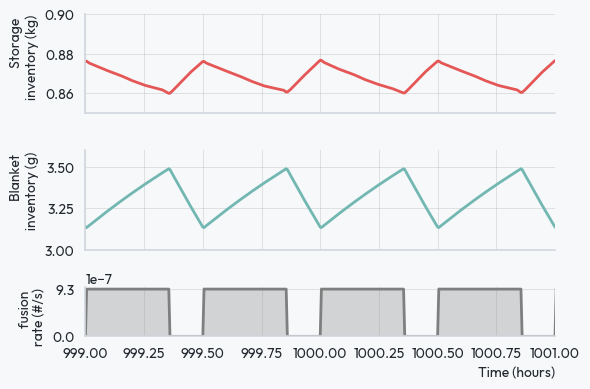

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 4), sharex=True, gridspec_kw={"height_ratios": [2, 2, 1]})

sim_time, data = ifc_scope.read()
plt.sca(axs[0])

for p, d in enumerate(data):
    lb = ifc_scope.labels[p] if p < len(ifc_scope.labels) else f"port {p}"
    if any([kw in lb.lower() for kw in ["storage"]]):
        plt.plot(sim_time / 3600, d, label=lb, linewidth=2, color=storage_colour)


plt.ylabel("Storage \ninventory (kg)")
plt.ylim(0.85, 0.9)

plt.sca(axs[1])
sim_time, data = ofc_scope.read()
for p, d in enumerate(data):
    lb = ofc_scope.labels[p] if p < len(ofc_scope.labels) else f"port {p}"
    if any([kw in lb.lower() for kw in ["blanket"]]):
        kg_to_g = 1e3
        plt.plot(sim_time / 3600, d * kg_to_g, label=lb, linewidth=2, color=blanket_colour)

plt.ylabel("Blanket \n inventory (g)")
plt.ylim(3, 3.6)
plt.sca(axs[2])
sim_time, data = fusion_rate_scope.read()
for p, d in enumerate(data):
    lb = fusion_rate_scope.labels[p] if p < len(fusion_rate_scope.labels) else f"port {p}"
    plt.plot(sim_time / 3600, d, label=lb, linewidth=2, color="tab:grey")
    plt.fill_between(sim_time / 3600, 0, d, alpha=0.3, color="tab:grey")

plt.yticks([0, data.max()])

plt.xlabel("Time (hours)")
plt.ylabel("fusion \n rate (#/s)")
plt.ylim(bottom=0)
plt.xlim(999, 1001)
plt.tight_layout()
plt.savefig("arc_cycle_zoomed.pdf")
plt.show()